<a href="https://colab.research.google.com/github/anyacallissta/MachineLearning_Ganjil_05/blob/main/UTS_2341720234_Anya_Callissta_Chriswantari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1 - Import and Load Dataset

In [1]:
!pip install annoy

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

file_id = "1UG8CxEOxo3_-VPSTdLhR8f3EcInjsjyZ"
url = f"https://drive.google.com/uc?id={file_id}"
df = pd.read_csv(url)
print("Ukuran dataset:", df.shape)
df.info()

Ukuran dataset: (30000, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BIL

### Step 2 - Preprocessing

In [3]:
# Tangani missing values
df.fillna(df.mean(), inplace=True)

# Buat fitur baru: rasio antara BALANCE (LIMIT_BAL) dan PURCHASES (pakai rata-rata BILL_AMT)
bill_cols = [col for col in df.columns if 'BILL_AMT' in col]
df['Avg_Bill'] = df[bill_cols].mean(axis=1)
df['Balance_to_Purchases'] = df['LIMIT_BAL'] / (df['Avg_Bill'].replace(0, np.nan))
df['Balance_to_Purchases'].fillna(df['Balance_to_Purchases'].median(), inplace=True)

print("\nFitur baru ditambahkan: 'Balance_to_Purchases'")

# Pilih hanya kolom numerik untuk clustering
num_df = df.drop(columns=['ID', 'default.payment.next.month']).select_dtypes(include=['float64', 'int64'])

# Normalisasi data numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)


Fitur baru ditambahkan: 'Balance_to_Purchases'


/tmp/ipython-input-2725378710.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Balance_to_Purchases'].fillna(df['Balance_to_Purchases'].median(), inplace=True)


### Step 3 - Clustering KMeans

In [4]:
best_k = 2
best_score = -1
scores_k = {}
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    try:
        s = silhouette_score(X_scaled, labels)
    except:
        s = -1
    scores_k[k] = s
    if s>best_score:
        best_score = s
        best_k = k
best_k, scores_k

(2,
 {2: np.float64(0.36387608539482097),
  3: np.float64(0.18852434117043718),
  4: np.float64(0.16483905043306374),
  5: np.float64(0.15801705764777974),
  6: np.float64(0.15862042331317702)})

In [5]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

sil_k = silhouette_score(X_scaled, labels_kmeans)
dbi_k = davies_bouldin_score(X_scaled, labels_kmeans)
print(f"\nKMeans Silhouette Score: {sil_k:.4f}")
print(f"KMeans Davies-Bouldin Index: {dbi_k:.4f}")


KMeans Silhouette Score: 0.3648
KMeans Davies-Bouldin Index: 1.4309


### Step 4 - Clustering DBScan

In [6]:
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
best_eps, best_sil = None, -1

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    if len(set(labels)) > 1 and len(set(labels)) < len(X_scaled):  # valid cluster
        sil = silhouette_score(X_scaled, labels)
        if sil > best_sil:
            best_sil, best_eps = sil, eps

print(f"Eps optimal: {best_eps:.3f}, Silhouette Score: {best_sil:.4f}")

Eps optimal: 2.500, Silhouette Score: 0.2347


In [8]:
dbscan = DBSCAN(eps=best_eps, min_samples=5)
labels_db = dbscan.fit_predict(X_scaled)

if len(set(labels_db)) > 1:
    sil_db = silhouette_score(X_scaled, labels_db)
    dbi_db = davies_bouldin_score(X_scaled, labels_db)
    print(f"\nDBSCAN Silhouette Score: {sil_db:.4f}")
    print(f"DBSCAN Davies-Bouldin Index: {dbi_db:.4f}")


DBSCAN Silhouette Score: 0.2347
DBSCAN Davies-Bouldin Index: 1.4958


### Step 5 - Clustering Visualization

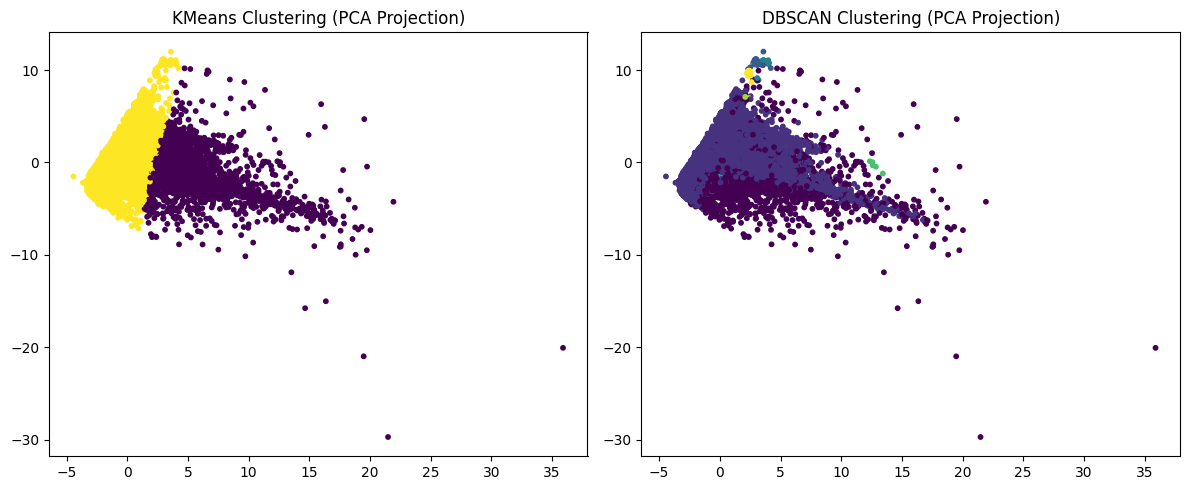

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis', s=10)
plt.title('KMeans Clustering (PCA Projection)')

plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_db, cmap='viridis', s=10)
plt.title('DBSCAN Clustering (PCA Projection)')
plt.tight_layout()
plt.show()

### Step 6 - Approximate Nearest Neighbor (Annoy)

In [12]:
f = X_scaled.shape[1]
annoy_index = AnnoyIndex(f, 'euclidean')

for i in range(X_scaled.shape[0]):
    annoy_index.add_item(i, X_scaled[i])

annoy_index.build(10)

# Ambil 3 titik query secara acak
query_indices = np.random.choice(range(X_scaled.shape[0]), size=3, replace=False)

for idx in query_indices:
    neighbors = annoy_index.get_nns_by_vector(X_scaled[idx], 5, include_distances=True)
    print(f"\nQuery index: {idx}")
    print("Tetangga terdekat (index, jarak):")
    for n_idx, dist in zip(neighbors[0], neighbors[1]):
        print(f"  {n_idx} - {dist:.4f}")


Query index: 5243
Tetangga terdekat (index, jarak):
  5243 - 0.0000
  7228 - 0.2259
  18911 - 0.2793
  11780 - 0.2798
  22875 - 0.3123

Query index: 2396
Tetangga terdekat (index, jarak):
  2396 - 0.0000
  14025 - 1.2035
  27110 - 1.2572
  11171 - 1.5474
  18137 - 1.5922

Query index: 7023
Tetangga terdekat (index, jarak):
  7023 - 0.0000
  2049 - 1.1844
  19694 - 1.3038
  15968 - 1.3497
  5368 - 1.6310
